In both of the previous examples—classifying movie reviews, and predicting fuel efficiency—we saw that the accuracy of our model on the validation data would peak after training for a number of epochs, and would then start decreasing.

In other words, our model would overfit to the training data. Learning how to deal with overfitting is important. Although it's often possible to achieve high accuracy on the training set, what we really want is to develop models that generalize well to a testing data (or data they haven't seen before).

The opposite of overfitting is underfitting. Underfitting occurs when there is still room for improvement on the test data. This can happen for a number of reasons: If the model is not powerful enough, is over-regularized, or has simply not been trained long enough. This means the network has not learned the relevant patterns in the training data.

If you train for too long though, the model will start to overfit and learn patterns from the training data that don't generalize to the test data. We need to strike a balance. Understanding how to train for an appropriate number of epochs as we'll explore below is a useful skill.

To prevent overfitting, the best solution is to use more training data. A model trained on more data will naturally generalize better. When that is no longer possible, the next best solution is to use techniques like regularization. These place constraints on the quantity and type of information your model can store. If a network can only afford to memorize a small number of patterns, the optimization process will force it to focus on the most prominent patterns, which have a better chance of generalizing well.

In this notebook, we'll explore two common regularization techniques—weight regularization and dropout—and use them to improve our IMDB movie review classification notebook.

In [1]:
from __future__ import absolute_import, division, print_function

import tensorflow as tf
from tensorflow import keras

import numpy as np
import matplotlib.pyplot as plt

print(tf.__version__)

/Users/gmontes/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


1.13.1


In [10]:
# Download the IMDB dataset.
# Rather than using an embedding as in the previous notebook, here we will multi-hot encode the sentences. 
# This model will quickly overfit to the training set.
NUM_WORDS = 10000

(train_data, train_labels), (test_data, test_labels) = keras.datasets.imdb.load_data(num_words=NUM_WORDS)

def multi_hot_sequences(sequences, dimension):
    # Create an all-zero matrix of shape (len(sequences), dimension)
    results = np.zeros((len(sequences), dimension))
    for i, word_indices in enumerate(sequences):
        results[i, word_indices] = 1.0  # set specific indices of results[i] to 1s
    return results


train_data = multi_hot_sequences(train_data, dimension=NUM_WORDS)
test_data = multi_hot_sequences(test_data, dimension=NUM_WORDS)

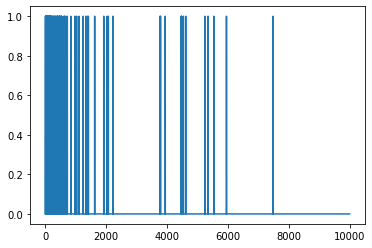

In [11]:
plt.plot(train_data[0])

### Demonstrate overfitting
The simplest way to prevent overfitting is to reduce the size of the model, i.e. the number of learnable parameters in the model (which is determined by the number of layers and the number of units per layer). In deep learning, the number of learnable parameters in a model is often referred to as the model's "capacity". Intuitively, a model with more parameters will have more "memorization capacity" and therefore will be able to easily learn a perfect dictionary-like mapping between training samples and their targets, a mapping without any generalization power, but this would be useless when making predictions on previously unseen data.

Always keep this in mind: deep learning models tend to be good at fitting to the training data, but the real challenge is generalization, not fitting.

On the other hand, if the network has limited memorization resources, it will not be able to learn the mapping as easily. To minimize its loss, it will have to learn compressed representations that have more predictive power. At the same time, if you make your model too small, it will have difficulty fitting to the training data. There is a balance between "too much capacity" and "not enough capacity".

Unfortunately, there is no magical formula to determine the right size or architecture of your model (in terms of the number of layers, or the right size for each layer). You will have to experiment using a series of different architectures.

To find an appropriate model size, it's best to start with relatively few layers and parameters, then begin increasing the size of the layers or adding new layers until you see diminishing returns on the validation loss. Let's try this on our movie review classification network.

In [14]:
# Create a baseline model.
baseline_model = keras.Sequential([
    # `input_shape` is only required here so that `.summary` works. 
    keras.layers.Dense(16, activation=tf.nn.relu, input_shape=(NUM_WORDS,)),
    keras.layers.Dense(16, activation=tf.nn.relu),
    keras.layers.Dense(1, activation=tf.nn.sigmoid)
])

baseline_model.compile(optimizer='adam',
                       loss='binary_crossentropy',
                       metrics=['accuracy', 'binary_crossentropy'])

baseline_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 16)                160016    
_________________________________________________________________
dense_4 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 17        
Total params: 160,305
Trainable params: 160,305
Non-trainable params: 0
_________________________________________________________________


In [15]:
baseline_history = baseline_model.fit(train_data,
                                      train_labels,
                                      epochs=20,
                                      batch_size=512,
                                      validation_data=(test_data, test_labels),
                                      verbose=2)

Train on 25000 samples, validate on 25000 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/20
 - 5s - loss: 0.4871 - acc: 0.8163 - binary_crossentropy: 0.4871 - val_loss: 0.3343 - val_acc: 0.8771 - val_binary_crossentropy: 0.3343
Epoch 2/20
 - 2s - loss: 0.2479 - acc: 0.9128 - binary_crossentropy: 0.2479 - val_loss: 0.2838 - val_acc: 0.8887 - val_binary_crossentropy: 0.2838
Epoch 3/20
 - 2s - loss: 0.1818 - acc: 0.9374 - binary_crossentropy: 0.1818 - val_loss: 0.2902 - val_acc: 0.8847 - val_binary_crossentropy: 0.2902
Epoch 4/20
 - 2s - loss: 0.1481 - acc: 0.9496 - binary_crossentropy: 0.1481 - val_loss: 0.3180 - val_acc: 0.8757 - val_binary_crossentropy: 0.3180
Epoch 5/20
 - 2s - loss: 0.1222 - acc: 0.9595 - binary_crossentropy: 0.1222 - val_loss: 0.3343 - val_acc: 0.8746 - val_binary_crossentropy: 0.3343
Epoch 6/20
 - 2s - loss: 0.1018 - acc: 0.9682 - binary_crossentropy: 0.1018 - val_loss: 0.3634 - val_acc: 0.8710 - val_binary_crossentropy: 0.3634
Epoch 7/20
 - 2s - l

In [16]:
# Create a smaller model.
smaller_model = keras.Sequential([
    keras.layers.Dense(4, activation=tf.nn.relu, input_shape=(NUM_WORDS,)),
    keras.layers.Dense(4, activation=tf.nn.relu),
    keras.layers.Dense(1, activation=tf.nn.sigmoid)
])

smaller_model.compile(optimizer='adam',
                loss='binary_crossentropy',
                metrics=['accuracy', 'binary_crossentropy'])

smaller_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 4)                 40004     
_________________________________________________________________
dense_7 (Dense)              (None, 4)                 20        
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 5         
Total params: 40,029
Trainable params: 40,029
Non-trainable params: 0
_________________________________________________________________


In [17]:
smaller_history = smaller_model.fit(train_data,
                                    train_labels,
                                    epochs=20,
                                    batch_size=512,
                                    validation_data=(test_data, test_labels),
                                    verbose=2)

Train on 25000 samples, validate on 25000 samples
Epoch 1/20
 - 3s - loss: 0.6053 - acc: 0.6642 - binary_crossentropy: 0.6053 - val_loss: 0.5450 - val_acc: 0.7477 - val_binary_crossentropy: 0.5450
Epoch 2/20
 - 2s - loss: 0.4959 - acc: 0.8362 - binary_crossentropy: 0.4959 - val_loss: 0.4945 - val_acc: 0.8219 - val_binary_crossentropy: 0.4945
Epoch 3/20
 - 2s - loss: 0.4465 - acc: 0.8864 - binary_crossentropy: 0.4465 - val_loss: 0.4722 - val_acc: 0.8379 - val_binary_crossentropy: 0.4722
Epoch 4/20
 - 2s - loss: 0.4127 - acc: 0.9111 - binary_crossentropy: 0.4127 - val_loss: 0.4531 - val_acc: 0.8629 - val_binary_crossentropy: 0.4531
Epoch 5/20
 - 2s - loss: 0.3862 - acc: 0.9290 - binary_crossentropy: 0.3862 - val_loss: 0.4513 - val_acc: 0.8530 - val_binary_crossentropy: 0.4513
Epoch 6/20
 - 2s - loss: 0.3622 - acc: 0.9400 - binary_crossentropy: 0.3622 - val_loss: 0.4309 - val_acc: 0.8762 - val_binary_crossentropy: 0.4309
Epoch 7/20
 - 2s - loss: 0.3398 - acc: 0.9510 - binary_crossentropy:

In [18]:
# Create a bigger model.
bigger_model = keras.models.Sequential([
    keras.layers.Dense(512, activation=tf.nn.relu, input_shape=(NUM_WORDS,)),
    keras.layers.Dense(512, activation=tf.nn.relu),
    keras.layers.Dense(1, activation=tf.nn.sigmoid)
])

bigger_model.compile(optimizer='adam',
                     loss='binary_crossentropy',
                     metrics=['accuracy','binary_crossentropy'])

bigger_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 512)               5120512   
_________________________________________________________________
dense_10 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 513       
Total params: 5,383,681
Trainable params: 5,383,681
Non-trainable params: 0
_________________________________________________________________


In [19]:
bigger_history = bigger_model.fit(train_data, train_labels,
                                  epochs=20,
                                  batch_size=512,
                                  validation_data=(test_data, test_labels),
                                  verbose=2)

Train on 25000 samples, validate on 25000 samples
Epoch 1/20
 - 8s - loss: 0.3397 - acc: 0.8575 - binary_crossentropy: 0.3397 - val_loss: 0.2944 - val_acc: 0.8802 - val_binary_crossentropy: 0.2944
Epoch 2/20
 - 8s - loss: 0.1443 - acc: 0.9488 - binary_crossentropy: 0.1443 - val_loss: 0.3380 - val_acc: 0.8711 - val_binary_crossentropy: 0.3380
Epoch 3/20
 - 8s - loss: 0.0497 - acc: 0.9854 - binary_crossentropy: 0.0497 - val_loss: 0.4586 - val_acc: 0.8667 - val_binary_crossentropy: 0.4586
Epoch 4/20
 - 8s - loss: 0.0083 - acc: 0.9982 - binary_crossentropy: 0.0083 - val_loss: 0.6054 - val_acc: 0.8640 - val_binary_crossentropy: 0.6054
Epoch 5/20
 - 8s - loss: 0.0011 - acc: 1.0000 - binary_crossentropy: 0.0011 - val_loss: 0.6856 - val_acc: 0.8698 - val_binary_crossentropy: 0.6856
Epoch 6/20
 - 8s - loss: 2.3788e-04 - acc: 1.0000 - binary_crossentropy: 2.3788e-04 - val_loss: 0.7300 - val_acc: 0.8699 - val_binary_crossentropy: 0.7300
Epoch 7/20
 - 8s - loss: 1.3708e-04 - acc: 1.0000 - binary_c

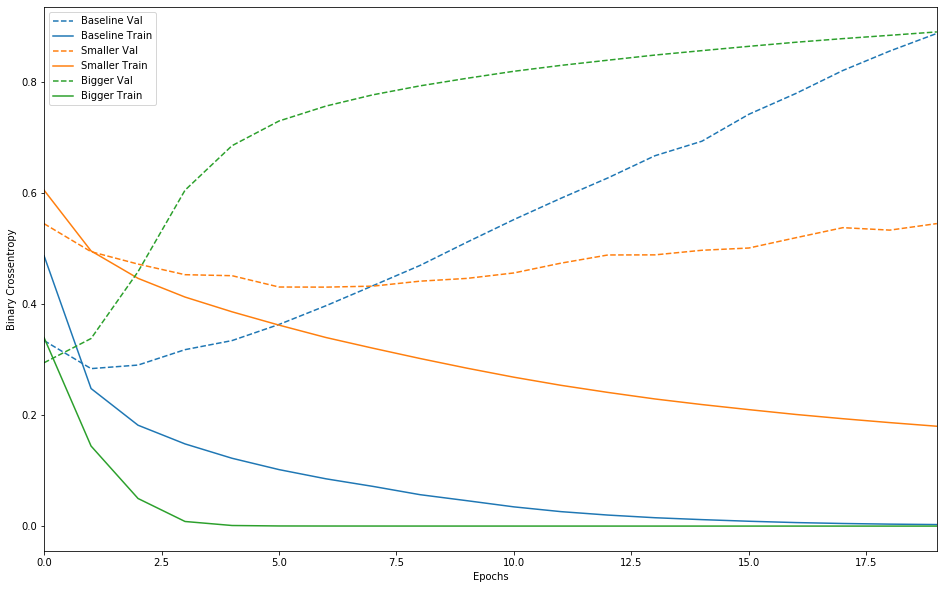

In [20]:
# Plot the training and validation loss.
def plot_history(histories, key='binary_crossentropy'):
  plt.figure(figsize=(16,10))
    
  for name, history in histories:
    val = plt.plot(history.epoch, history.history['val_'+key],
                   '--', label=name.title()+' Val')
    plt.plot(history.epoch, history.history[key], color=val[0].get_color(),
             label=name.title()+' Train')

  plt.xlabel('Epochs')
  plt.ylabel(key.replace('_',' ').title())
  plt.legend()

  plt.xlim([0,max(history.epoch)])


plot_history([('baseline', baseline_history),
              ('smaller', smaller_history),
              ('bigger', bigger_history)])

Notice that the larger network begins overfitting almost right away, after just one epoch, and overfits much more severely. The more capacity the network has, the quicker it will be able to model the training data (resulting in a low training loss), but the more susceptible it is to overfitting (resulting in a large difference between the training and validation loss).

# Strategies
### Add weight regularization
You may be familiar with Occam's Razor principle: given two explanations for something, the explanation most likely to be correct is the "simplest" one, the one that makes the least amount of assumptions. This also applies to the models learned by neural networks: given some training data and a network architecture, there are multiple sets of weights values (multiple models) that could explain the data, and simpler models are less likely to overfit than complex ones.

A "simple model" in this context is a model where the distribution of parameter values has less entropy (or a model with fewer parameters altogether, as we saw in the section above). Thus a common way to mitigate overfitting is to put constraints on the complexity of a network by forcing its weights only to take small values, which makes the distribution of weight values more "regular". This is called "weight regularization", and it is done by adding to the loss function of the network a cost associated with having large weights. This cost comes in two flavors:

L1 regularization, where the cost added is proportional to the absolute value of the weights coefficients (i.e. to what is called the "L1 norm" of the weights).

L2 regularization, where the cost added is proportional to the square of the value of the weights coefficients (i.e. to what is called the squared "L2 norm" of the weights). L2 regularization is also called weight decay in the context of neural networks. Don't let the different name confuse you: weight decay is mathematically the exact same as L2 regularization.

In [21]:
# Let's add L2 weight regularization now.
# l2(0.001) means that every coefficient in the weight matrix of the layer will add 
# 0.001 * weight_coefficient_value**2 to the total loss of the network.
l2_model = keras.models.Sequential([
    keras.layers.Dense(16, kernel_regularizer=keras.regularizers.l2(0.001),
                       activation=tf.nn.relu, input_shape=(NUM_WORDS,)),
    keras.layers.Dense(16, kernel_regularizer=keras.regularizers.l2(0.001),
                       activation=tf.nn.relu),
    keras.layers.Dense(1, activation=tf.nn.sigmoid)
])

l2_model.compile(optimizer='adam',
                 loss='binary_crossentropy',
                 metrics=['accuracy', 'binary_crossentropy'])

l2_model_history = l2_model.fit(train_data, train_labels,
                                epochs=20,
                                batch_size=512,
                                validation_data=(test_data, test_labels),
                                verbose=2)

Train on 25000 samples, validate on 25000 samples
Epoch 1/20
 - 3s - loss: 0.5107 - acc: 0.8117 - binary_crossentropy: 0.4699 - val_loss: 0.3715 - val_acc: 0.8769 - val_binary_crossentropy: 0.3268
Epoch 2/20
 - 2s - loss: 0.2978 - acc: 0.9093 - binary_crossentropy: 0.2485 - val_loss: 0.3362 - val_acc: 0.8861 - val_binary_crossentropy: 0.2836
Epoch 3/20
 - 2s - loss: 0.2469 - acc: 0.9300 - binary_crossentropy: 0.1916 - val_loss: 0.3481 - val_acc: 0.8832 - val_binary_crossentropy: 0.2910
Epoch 4/20
 - 2s - loss: 0.2271 - acc: 0.9410 - binary_crossentropy: 0.1681 - val_loss: 0.3692 - val_acc: 0.8761 - val_binary_crossentropy: 0.3089
Epoch 5/20
 - 2s - loss: 0.2111 - acc: 0.9490 - binary_crossentropy: 0.1499 - val_loss: 0.3781 - val_acc: 0.8757 - val_binary_crossentropy: 0.3161
Epoch 6/20
 - 2s - loss: 0.1999 - acc: 0.9542 - binary_crossentropy: 0.1370 - val_loss: 0.3919 - val_acc: 0.8734 - val_binary_crossentropy: 0.3286
Epoch 7/20
 - 2s - loss: 0.1934 - acc: 0.9569 - binary_crossentropy:

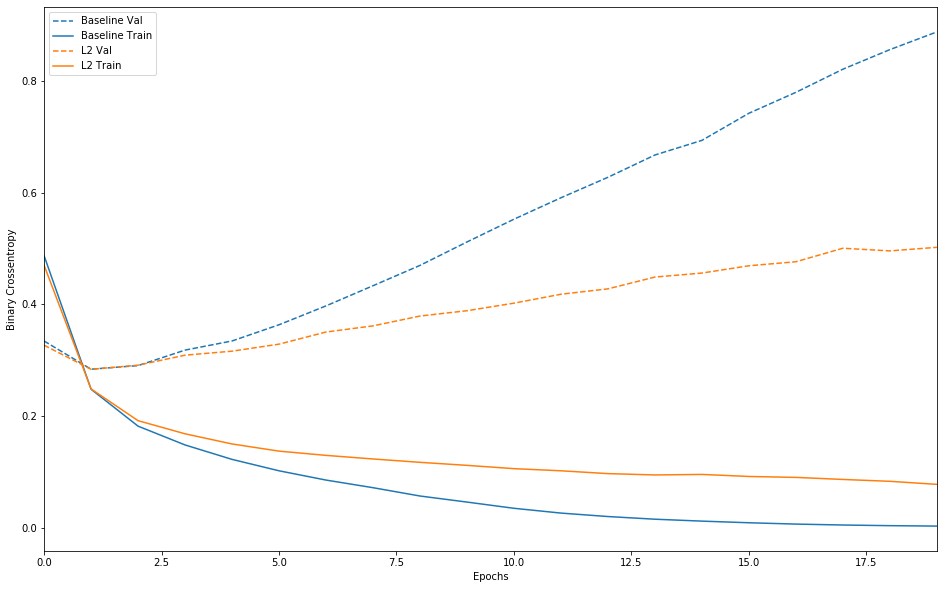

In [23]:
# Note that because this penalty is only added at training time, 
# the loss for this network will be much higher at training than at test time.
plot_history([('baseline', baseline_history),
              ('l2', l2_model_history)])

### Add dropout
Dropout is one of the most effective and most commonly used regularization techniques for neural networks, developed by Hinton and his students at the University of Toronto. Dropout, applied to a layer, consists of randomly "dropping out" (i.e. set to zero) a number of output features of the layer during training. Let's say a given layer would normally have returned a vector [0.2, 0.5, 1.3, 0.8, 1.1] for a given input sample during training; after applying dropout, this vector will have a few zero entries distributed at random, e.g. [0, 0.5, 1.3, 0, 1.1]. The "dropout rate" is the fraction of the features that are being zeroed-out; it is usually set between 0.2 and 0.5. At test time, no units are dropped out, and instead the layer's output values are scaled down by a factor equal to the dropout rate, so as to balance for the fact that more units are active than at training time.

In [24]:
# Let's add two Dropout layers in our IMDB network to see how well they do at reducing overfitting.
dpt_model = keras.models.Sequential([
    keras.layers.Dense(16, activation=tf.nn.relu, input_shape=(NUM_WORDS,)),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(16, activation=tf.nn.relu),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(1, activation=tf.nn.sigmoid)
])

dpt_model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy','binary_crossentropy'])

dpt_model_history = dpt_model.fit(train_data, train_labels,
                                  epochs=20,
                                  batch_size=512,
                                  validation_data=(test_data, test_labels),
                                  verbose=2)

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Train on 25000 samples, validate on 25000 samples
Epoch 1/20
 - 4s - loss: 0.6245 - acc: 0.6400 - binary_crossentropy: 0.6245 - val_loss: 0.4919 - val_acc: 0.8511 - val_binary_crossentropy: 0.4919
Epoch 2/20
 - 2s - loss: 0.4645 - acc: 0.7908 - binary_crossentropy: 0.4645 - val_loss: 0.3409 - val_acc: 0.8790 - val_binary_crossentropy: 0.3409
Epoch 3/20
 - 2s - loss: 0.3618 - acc: 0.8597 - binary_crossentropy: 0.3618 - val_loss: 0.2937 - val_acc: 0.8857 - val_binary_crossentropy: 0.2937
Epoch 4/20
 - 2s - loss: 0.2992 - acc: 0.8936 - binary_crossentropy: 0.2992 - val_loss: 0.2788 - val_acc: 0.8882 - val_binary_crossentropy: 0.2788
Epoch 5/20
 - 2s - loss: 0.2549 - acc: 0.9107 - binary_crossentropy: 0.2549 - val_loss: 0.2759 - val_acc: 0.8885 - val_binary_crossentropy: 0.2759
Epoch 6/20
 - 3s - loss: 0.2226 - acc: 0.9255 - binary_crossentropy: 0.2226 - val_loss: 0.2859 - val

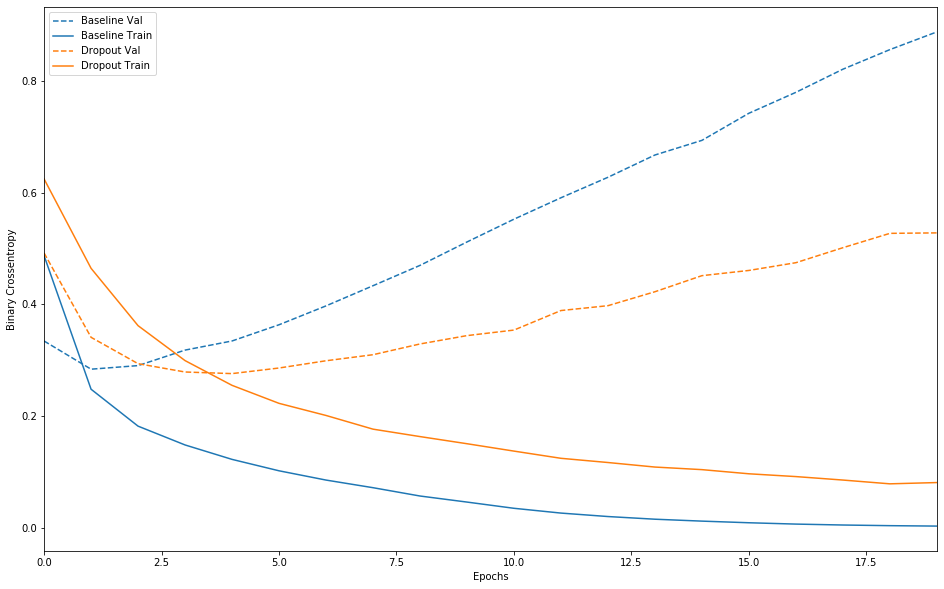

In [25]:
plot_history([('baseline', baseline_history),
              ('dropout', dpt_model_history)])

Adding dropout is a clear improvement over the baseline model.

### To recap
here the most common ways to prevent overfitting in neural networks:
- Get more training data.
- Reduce the capacity of the network.
- Add weight regularization.
- Add dropout.

And two important approaches not covered in this guide are data-augmentation and batch normalization.